In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score

In [2]:
data_path = os.path.join(os.path.dirname(os.getcwd()), "data", "class.csv")
data_path = os.path.join(os.path.dirname(os.getcwd()), "data", "class_mays.csv")
data_path = os.path.join(os.path.dirname(os.getcwd()), "data", "class_loc.csv")

In [3]:
df = pd.read_csv(data_path)

In [4]:
df = df[['Scheduled Setup Start', 'Scheduled Cleanup Complete', 'Room', 'Location', 'Primary Surgeon ID', 'Primary Service']]
df['Scheduled Setup Start']=pd.to_datetime(df['Scheduled Setup Start'])
df['Scheduled Cleanup Complete']=pd.to_datetime(df['Scheduled Cleanup Complete'])
df['Scheduled Room Duration']=(df['Scheduled Cleanup Complete']-df['Scheduled Setup Start']).astype('timedelta64[m]')
df = df.dropna()
df = df[df['Room'].str.contains(r'\d', regex=True)]
df = df[df['Location']=='MAIN OR']
# df = df[df['Location']=='MAYS OR']
df['Room']=df.apply(lambda row: int(re.search(r'\d+', row['Room']).group()), axis = 1)
df = df.loc[df['Room']<41]

df['SurgeonID'] = df.groupby('Primary Surgeon ID').ngroup()
df=df.assign(CaseID=range(len(df)))

In [5]:
X = df[['Primary Surgeon ID', 'Primary Service', 'Scheduled Room Duration']]

In [17]:
y = df['Room']
# y = df['Location']

In [18]:
seed = 1  # so that the result is reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state = seed)

In [19]:
features_to_encode = ['Primary Surgeon ID', 'Primary Service']

In [20]:
col_trans = make_column_transformer(
                        (OneHotEncoder(),features_to_encode),
                        remainder = "passthrough"
                        )

In [21]:
rf_classifier = RandomForestClassifier(
                      min_samples_leaf=50,
                      n_estimators=150,
                      bootstrap=True,
                      oob_score=True,
                      n_jobs=-1,
                      random_state=seed,
                      max_features='auto')

In [22]:
pipe = make_pipeline(col_trans, rf_classifier)
# pipe.fit(X_train, y_train)
pipe.fit(X, y)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['Primary Surgeon ID',
                                                   'Primary Service'])],
                                   verbose=False)),
                ('rando...
                 RandomForestClassifie

In [24]:
y_pred = pipe.predict(X)
accuracy_score(y, y_pred)
print(f"The accuracy of the model is {round(accuracy_score(y,y_pred),3)*100} %")

The accuracy of the model is 29.2 %


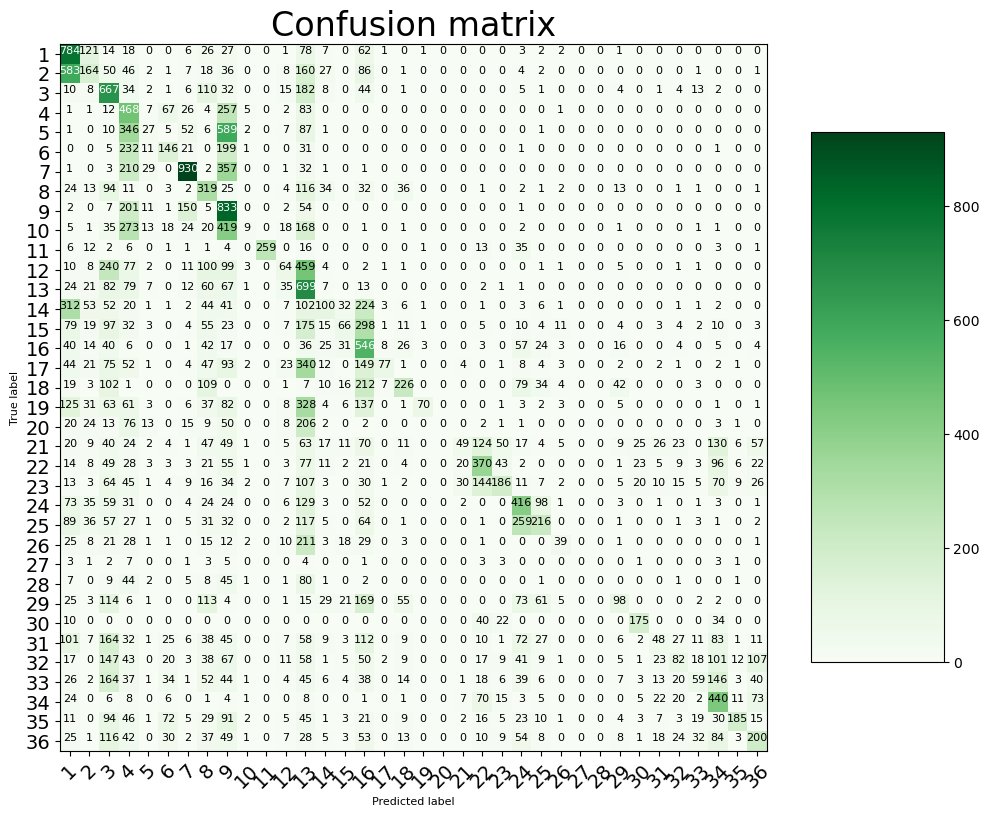

In [26]:
import itertools
def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens): # can change color 
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 8, horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        plt.grid(None)
        plt.tight_layout()
        plt.ylabel('True label', size = 8)
        plt.xlabel('Predicted label', size = 8)

# Let's plot it out
cm = confusion_matrix(y, y_pred)
plot_confusion_matrix(cm, classes = [str(i) for i in range(1,37)])

In [27]:
print(rf_classifier.feature_importances_)
print(f" There are {len(rf_classifier.feature_importances_)} features in total")

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.99674933e-04 0.00000000e+00 0.00000000e+00 9.08522333e-05
 7.44275524e-04 8.82463720e-05 3.17151533e-04 6.42142411e-04
 0.00000000e+00 5.18212241e-04 3.92331839e-05 9.95669028e-04
 1.76947601e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.44173200e-05 2.15854355e-03 9.30267456e-04 1.33017655e-02
 0.00000000e+00 3.65258143e-04 1.07475499e-05 0.00000000e+00
 0.00000000e+00 5.18580966e-03 1.33520433e-02 2.44954447e-04
 2.64327176e-04 2.14741629e-03 0.00000000e+00 0.00000000e+00
 4.05757733e-02 2.75712186e-03 0.00000000e+00 9.29043859e-05
 2.76516457e-03 2.21223247e-03 0.00000000e+00 5.17701303e-04
 2.76352273e-04 2.28767887e-04 7.49991300e-05 8.19978980e-04
 3.33896287e-02 4.68812640e-04 3.56433229e-03 2.50315120e-04
 1.46329393e-04 3.23986901e-04 0.00000000e+00 0.00000000e+00
 1.19113852e-03 3.69032533e-04 0.00000000e+00 1.23246735e-04
 0.00000000e+00 9.87027535e-05 1.32010986e-03 0.00000000e+00
 0.00000000e+00 6.793886

In [28]:
def encode_and_bind(original_dataframe, features_to_encode):
    dummies = pd.get_dummies(original_dataframe[features_to_encode])
    res = pd.concat([dummies, original_dataframe], axis=1)
    res = res.drop(features_to_encode, axis=1)
    return(res)
X_train_encoded = encode_and_bind(X_train, features_to_encode)

In [29]:
feature_importances = list(zip(X_train_encoded, rf_classifier.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
[print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked];

Feature: Primary Service_UROLOGY             Importance: 0.013352043292147859
Feature: Primary Service_SURG ONC - MELANOMA Importance: 0.013301765457735546
Feature: Primary Service_THRCV - VASCULAR SURGERY Importance: 0.005185809656887569
Feature: Primary Service_SURG ONC - GENERAL  Importance: 0.002158543552701587
Feature: Primary Service_PULMONARY           Importance: 0.0017694760088838475
Feature: Primary Service_GYN - GENERAL GYNECOLOGY Importance: 0.0009996749332445436
Feature: Primary Service_PODIATRY            Importance: 0.0009956690281779684
Feature: Primary Service_SURG ONC - LIVER    Importance: 0.0009302674555377219
Feature: Primary Service_NEUROSURGERY        Importance: 0.0007442755237300709
Feature: Primary Service_ORTHOPEDIC ONCOLOGY Importance: 0.0006421424114334317
Feature: Primary Service_PLS - OPHTHALMOLOGIC PLASTIC SURGERY Importance: 0.0005182122407710456
Feature: Primary Service_SURG ONC - PEDI     Importance: 0.00036525814283258103
Feature: Primary Service_ORA

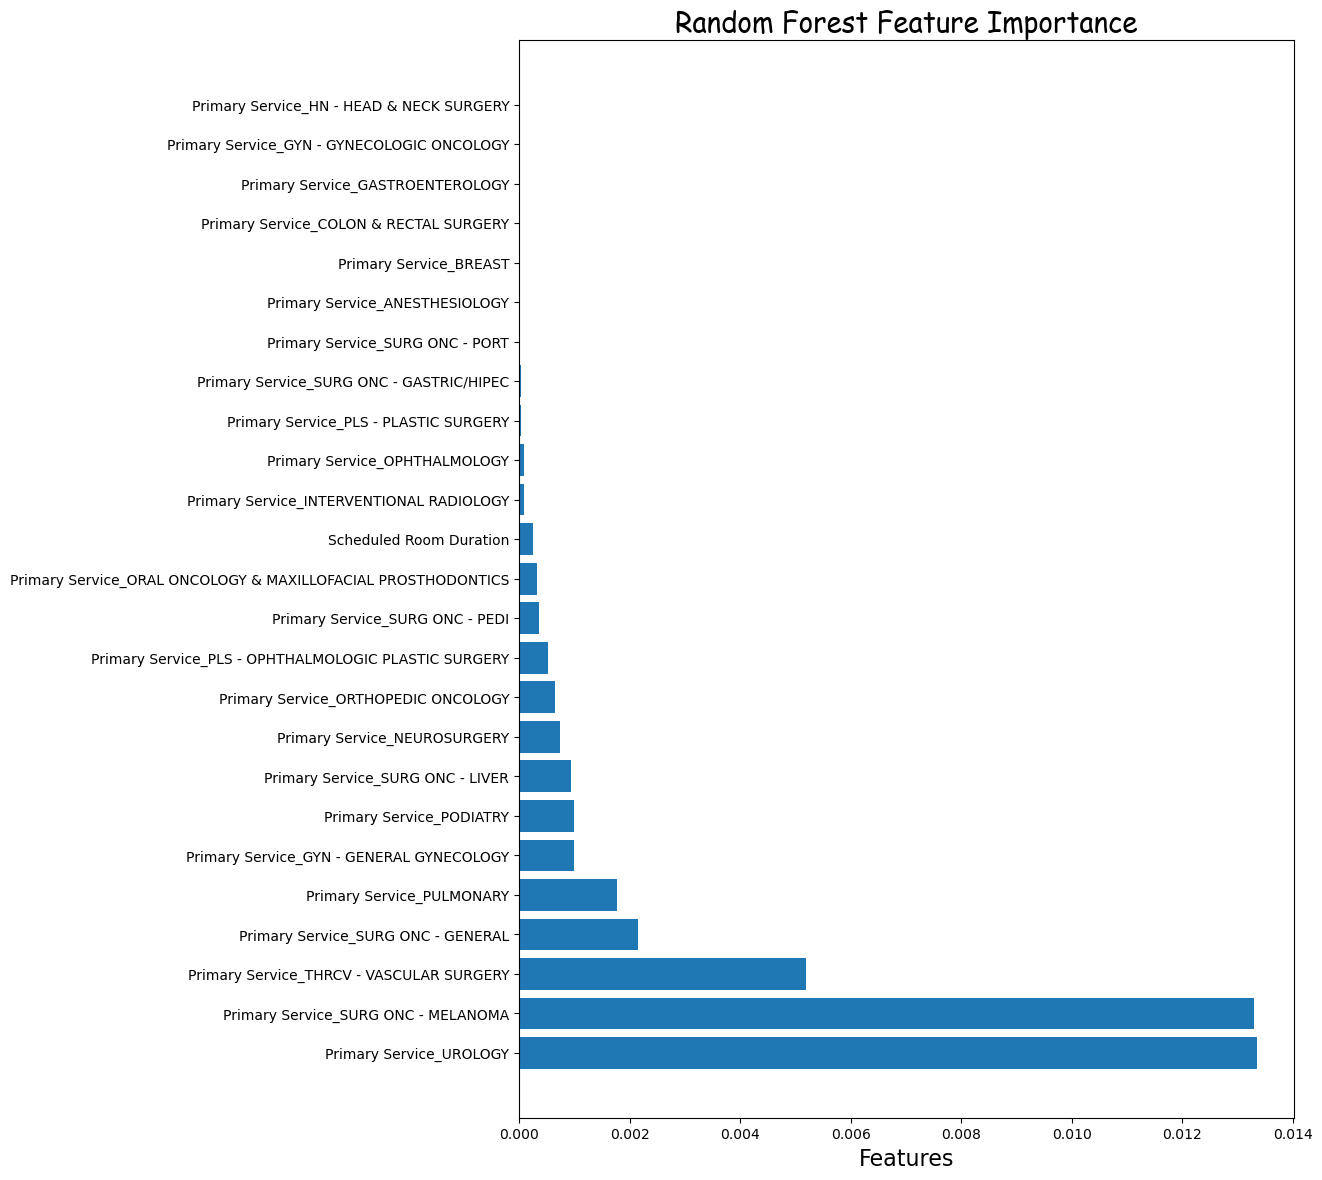

In [30]:
feature_names_25 = [i[0] for i in feature_importances_ranked[:25]]
y_ticks = np.arange(0, len(feature_names_25))
x_axis = [i[1] for i in feature_importances_ranked[:25]]
plt.figure(figsize = (10, 14))
plt.barh(feature_names_25, x_axis)   #horizontal barplot
plt.title('Random Forest Feature Importance',
          fontdict= {'fontname':'Comic Sans MS','fontsize' : 20})
plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()